# Inference plots - Autocorrelation plot

This example builds on the [adaptive covariance MCMC example](https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb), and shows you a different way to plot the results.

Inference plots:
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* __Autocorrelation__
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* [Pairwise scatterplots with KDE](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-kde-plots.ipynb)

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [2]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform log-prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Perform sampling using MCMC, with a single chain
x0 = real_parameters * 1.2
mcmc = pints.MCMCSampling(log_posterior, 1, [x0])
mcmc.set_max_iterations(6000)
mcmc.set_verbose(False)

## Autocorrelation

The [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) in a Markov chain indicates how much each sample in the chain differs from the next. Checking for (lack of) autocorrelation is an easy way to check if your MCMC routine is converging. It can easily be plotted using Matplotlib's [acorr method](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.acorr).

In [2]:
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


In [3]:
# Select chain 0 and discard warm-up
chain = chains[0]
chain = chain[3000:]

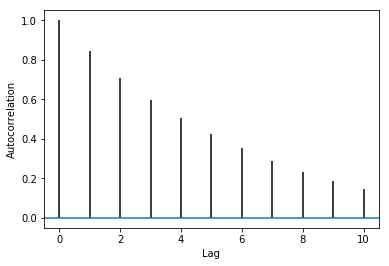

In [4]:
plt.figure()
plt.acorr(chain[:,0] - np.mean(chain[:,0]))
plt.xlim(-0.5, 10.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()